## **Finding a maximum independant set using a quantum computer with neutral atoms**

The first step is to create a graph on which we want to execute a MIS algorithm.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

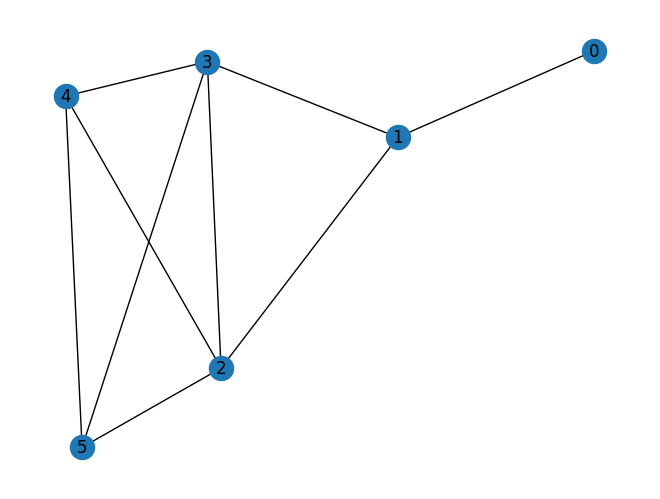

In [2]:
#creating a graph with determinated edges

G = nx.Graph()
edges = edges = [(0,1), (1, 2), (1, 3), (3, 2), (3, 4), (3, 5), (2, 4), (2, 5), (4, 5)] #be careful, the nodes must be noted from 0 to n where n is the number of total nodes
G.add_edges_from(edges)

#setting the position of the nodes using spring_layout
pos = nx.spring_layout(G, seed = 42)#the seed can be changed, but the seed 42 is used by the Quantum_MIS class

#plot the graph
nx.draw(G, pos = pos, with_labels = True)
plt.show()

## Solving the register for the maximal independant set using a quantum adiabatic algorithm

We first need to create our register

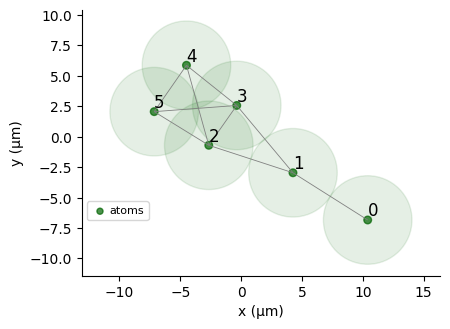

In [3]:
#creating the quantum solver object for the qaa
from QMIS_code.Quantum_MIS import Quantum_MIS
from pulser.devices import DigitalAnalogDevice

#We first want to specify the device used to run the quantum_MIS algorithm 
device = DigitalAnalogDevice

#we only need to pass the graph object in the Quantum_MIS class
mis_solution = Quantum_MIS(G, device)

#the Quantum_MIS class creates a register for each connected components
# we can now print the registers created
mis_solution.print_regs() 


Now that we have created the register, we need to create a Pulse. In this project, 5 types of pulse have been implemented. 
- "Rise_sweep_fall" -> A pulse that starts to 0, rises during a quarter of the total time to the omega specified, stays constant during half of the total time, and falls to 0 during a quarter of the total time.

- "Pyramid" -> A pulse that starts at a certain value that is Omega - delta. The pulse stays at this value for a quarter of the total time, does a Rise_Fall pulse for half of the total time, and finally stays constant at Omega-delta for the last quarter of the total time.

- "Blackman" -> This pulse is a normal form with a total area of Omega with a lenght given by the time.

- "Rise_fall" -> This pulse is only the rise and fall part of the Rise_Sweep_Fall pulse. It rises during half of the time from 0 to Omega and falls back to 0 for the last half of the total time.

- "Waveform" -> This pulse starts at 0, is at Omega at half of the total time, and falls back to 0 at the end, but follows a waveform pattern instead of a linear pattern like the Rise_Fall. 

In [4]:
from QMIS_code.pulse_utils import Pulse_constructor

T = 4000 #time of the pulse in ns, the time limit is 4000.

pulse_type = "Rise_sweep_fall" #the pulse type used. Try other pulse type to see the differences in the answer

#constructing the pulse using the time and the pulse_type
pulse = Pulse_constructor(T, pulse_type)




It's now time to run the quantum_MIS algorithm. This algorithm takes a graph with all its connected components and resolves it with a quantum adiabatic algorithm and combines them to return a count dictionnary.

In [5]:
shots = 100 #the number of shots doesn't have to be this big for the results to be good

counts_results = mis_solution.run(pulse, progress_bar=False, shots = shots)
print(counts_results)

[Counter({'100010': 29, '100001': 22, '100100': 18, '101000': 11, '010001': 9, '100000': 4, '000010': 3, '010010': 3, '000001': 1})]
{'000001': 1, '000010': 3, '010001': 9, '010010': 3, '100000': 4, '100001': 22, '100010': 29, '100100': 18, '101000': 11}


There's an argument in the run meethod named `generate_histogram`. Here's an exemple of the histogram it would produces:

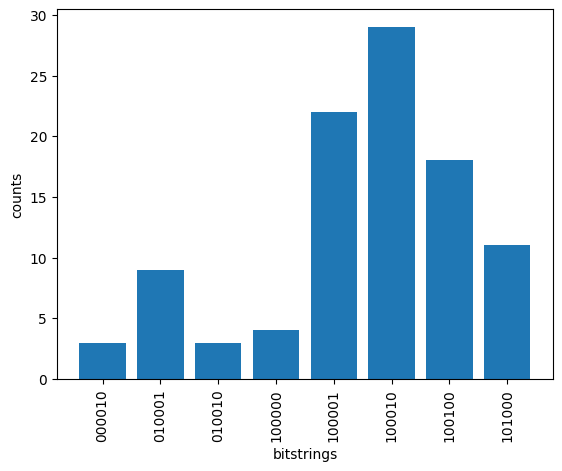

In [6]:
from QMIS_code.QMIS_utils import plot_histogram

plot_histogram(counts_results, shots) #you can also give a file_name in argument in this function to save the histogram in your repository

We can now obtain the maximum independant set of the graph by extracting the maximal bitstring and find the related nodes: 

In [7]:

best_bitstring = max(zip(counts_results.values(),counts_results.keys()))[1]
print("the best bitstring in the histogram is: ", best_bitstring)

independant_nodes = []
for j in range(len(best_bitstring)):
    if best_bitstring[j] == "1":
        independant_nodes.append(j)

print("The maximal independant set nodes are: ", independant_nodes)

the best bitstring in the histogram is:  100010
The maximal independant set nodes are:  [0, 4]


Note that the quantum algorithm doesn't only give one correct answer, the bitstrings "010101", "100101" are equally good solution.
We can now see the graph with the given nodes in solution. You can test it with the other best bitstrings of the histogram to see the differences.

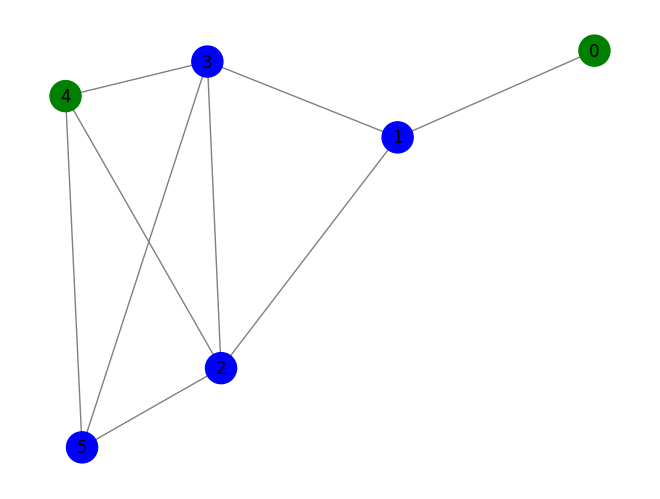

In [8]:
#mis nodes are green and not mis nodes are blue
node_colors = ["green" if node in independant_nodes else "blue" for node in G.nodes]
nx.draw(
    G,
    with_labels=True,
    node_color=node_colors,
    node_size=500,
    edge_color="gray",
    pos=pos,
)
plt.show()